## Thesis Code

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd
import itertools
import math
import scipy.stats as stats

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size = 14)
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

## Constants

In [3]:
ASSET_NAMES = ['US Equities','Intl. Equities','U.S. Gov. Bonds','Intl. Gov. Bonds']

## All of these functions are allocation strategies

In [4]:
class Allocation(object):
    """Class with static methods to compute asset allocation."""
    equity_ratio = np.array([0.6,0.4,0,0])
    bond_ratio = np.array([0,0,0.7,0.3])
    
    bm_wealth_path = np.load('numpy/bm_path.npy')
    bm_wealth_path_72 = np.load('numpy/bm_path_72.npy')
    
    @classmethod
    def fme(cls,age,aux_dict=None):
        '''Fixed-Mix Equity: 80% Stock, 20% Bond.'''
        return 0.8*cls.equity_ratio + 0.2*cls.bond_ratio

    @classmethod
    def fmb(cls,age,aux_dict=None):
        '''Fixed-Mix Bond: 20% Stock, 80% Bond.'''
        return 0.2*cls.equity_ratio + 0.8*cls.bond_ratio  
    
    @classmethod
    def _vgp_equity_alloc(cls,age,aux_dict=None):
        '''Based on Vanguard target date fund offerings.'''
        retirement_age = aux_dict['retirement_age']

        yrs_to_retirement = retirement_age - age
        
        if yrs_to_retirement > 25:
            equity_alloc = 0.9
        elif yrs_to_retirement > -7:
            equity_alloc = 0.3 + 0.6 * (yrs_to_retirement + 7)/32    
        else:
            equity_alloc = 0.3
            
        return equity_alloc
    
    @classmethod
    def sgp(cls,age,aux_dict=None):
        '''Standard Glide Path: Based on Vanguard target date fund offerings.'''            
        equity_alloc = Allocation._vgp_equity_alloc(age, aux_dict)
        bond_alloc = 1 - equity_alloc
        
        allocation = equity_alloc * cls.equity_ratio + bond_alloc * cls.bond_ratio
        
        return allocation
    
    @classmethod
    def rgp(cls,age,aux_dict=None):
        '''Reverse Glide Path: Based on Vanguard target date fund offerings.'''
        retirement_age = aux_dict['retirement_age']

        yrs_to_retirement = retirement_age - age
        
        if yrs_to_retirement > 25:
            equity_alloc = 0.3
        elif yrs_to_retirement > -7:
            equity_alloc = 0.3 + 0.6 * (25 - yrs_to_retirement)/32    
        else:
            equity_alloc = 0.9
        
        bond_alloc = 1 - equity_alloc
        
        return equity_alloc * cls.equity_ratio + bond_alloc * cls.bond_ratio
    
    @classmethod
    def dgp(cls,age,aux_dict=None):
        '''Dynamic strategy. If fall behind, tilt towards more equity.'''
        wealth_path = aux_dict['wealth_path']
        curr_wealth = wealth_path[-1]
        
        if len(wealth_path) > 1:
            wealth_median = cls.bm_wealth_path[len(wealth_path) - 1]
            
            if curr_wealth > wealth_median:
                return Allocation.sgp(age, aux_dict)
            else:
                equity_alloc = Allocation._vgp_equity_alloc(age, aux_dict)
                equity_alloc = min(1, equity_alloc + 0.2)
                bond_alloc = 1 - equity_alloc
                return equity_alloc * cls.equity_ratio + bond_alloc * cls.bond_ratio
        return Allocation.sgp(age,aux_dict)

    @classmethod
    def dgp_70(cls,age,aux_dict=None):
        '''Dynamic strategy. If fall behind, tilt towards more equity.'''
        wealth_path = aux_dict['wealth_path']
        curr_wealth = wealth_path[-1]
        
        if len(wealth_path) > 1:
            wealth_median = cls.bm_wealth_path_70[len(wealth_path) - 1]
            
            if curr_wealth > wealth_median:
                return Allocation.sgp(age, aux_dict)
            else:
                equity_alloc = Allocation._vgp_equity_alloc(age, aux_dict)
                equity_alloc = min(1, equity_alloc + 0.2)
                bond_alloc = 1 - equity_alloc
                return equity_alloc * cls.equity_ratio + bond_alloc * cls.bond_ratio
        return Allocation.sgp(age,aux_dict)

    @classmethod
    def pgp(cls, age, aux_dict=None):
        '''Play-safe dynamic strategy. If rise ahead, tilt towards more bond.'''
        wealth_path = aux_dict['wealth_path']
        curr_wealth = wealth_path[-1]

        if len(wealth_path) > 1:
            # Assume 'bm_wealth_path' is the benchmark
            wealth_benchmark = cls.bm_wealth_path[len(wealth_path) - 1]

            # If current wealth is ahead of the benchmark
            if curr_wealth > wealth_benchmark:
                # Decrease equity allocation to play it safe
                equity_alloc = Allocation._vgp_equity_alloc(age, aux_dict)
                # Decreasing the equity allocation by a certain factor, e.g., 0.2
                equity_alloc = max(0, equity_alloc - 0.2)
                bond_alloc = 1 - equity_alloc
                return equity_alloc * cls.equity_ratio + bond_alloc * cls.bond_ratio
            else:
                # If not ahead, follow the standard glide path
                return Allocation.sgp(age, aux_dict)

        # Default to standard glide path if wealth path length is 1 or less
        return Allocation.sgp(age, aux_dict)
    
    @classmethod
    def dzgp(cls, age, aux_dict=None):
        '''Dynamic-Zone Glide Path combines the behaviors of both DGP and 
        PGP by overlaying an equity tilt when falling behind the benchmark 
        wealth path and overlaying a bond tilt when exceeding the benchmark wealth path.'''
        wealth_path = aux_dict['wealth_path']
        curr_wealth = wealth_path[-1]

        if len(wealth_path) > 1:
            wealth_benchmark = cls.bm_wealth_path[len(wealth_path) - 1]

            equity_alloc = Allocation._vgp_equity_alloc(age, aux_dict)

            # If current wealth is behind the benchmark, increase equity allocation
            if curr_wealth < wealth_benchmark:
                equity_alloc = min(1, equity_alloc + 0.2)  # increase equity by a factor, e.g., 0.2
            # If current wealth is ahead of the benchmark, decrease equity allocation
            elif curr_wealth > wealth_benchmark:
                equity_alloc = max(0, equity_alloc - 0.2)  # decrease equity by a factor, e.g., 0.2

            bond_alloc = 1 - equity_alloc
            return equity_alloc * cls.equity_ratio + bond_alloc * cls.bond_ratio

        # Default to standard glide path if wealth path length is 1 or less
        return Allocation.sgp(age, aux_dict)



## All these functions are for plotting

In [5]:
class Plotting(object):
    """Class with static methods to plot results."""

    @classmethod 
    def _plot_scenarios(cls, xs, list_mtx_values, list_names, 
                        pctile_dotted=None, pctile_fill=49, figsize=(10,5),
                        title='Default Title',xlabel='X Values',ylabel='Y Values'):
        plt.figure(figsize=(10,5))

        for mtx_values, name in zip(list_mtx_values, list_names):
            # plot the median
            y_med = Port.calc_stat(mtx_values, lambda x: np.percentile(x, 50)) 
            a = plt.plot(xs,y_med,label=name)

            # plot the dotted lines
            if pctile_dotted != None:
                y_dotted_lower = Port.calc_stat(mtx_values, lambda x: np.percentile(x, 50-pctile_dotted))
                y_dotted_upper = Port.calc_stat(mtx_values, lambda x: np.percentile(x, 50+pctile_dotted))
                plt.plot(xs,y_dotted_lower,linestyle='--',color=a[0].get_color())
                plt.plot(xs,y_dotted_upper,linestyle='--',color=a[0].get_color())

            # plot the fill
            alpha=0.25
            y_fill_lower = Port.calc_stat(mtx_values, lambda x: np.percentile(x, 50-pctile_fill))
            y_fill_upper = Port.calc_stat(mtx_values, lambda x: np.percentile(x, 50+pctile_fill))
            plt.fill_between(xs, y_fill_lower, y_fill_upper,color=a[0].get_color(),interpolate=True,alpha=alpha)
        
        plt.title(title)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.show()
        
    @classmethod
    def wealth_path(cls,list_ports, list_names,num_periods,
                    pctile_dotted = None, pctile_fill=49,figsize=(10,5)):
        xs = [25 + x/12 for x in range(num_periods)]
        title = 'Wealth over time'
        ylabel = 'Wealth'
        xlabel = 'Age'
        
        list_port_wealth = [port.wealth_path() for port in list_ports]
        Plotting._plot_scenarios(xs, list_port_wealth, list_names, 
                                 pctile_dotted=pctile_dotted, pctile_fill=pctile_fill,
                                 figsize=figsize, title=title, ylabel=ylabel,xlabel=xlabel)
        
    @classmethod
    def relative_dd_path(cls,list_ports, list_names, num_periods, pctile_dotted = None, 
                         pctile_fill=49, figsize=(10,5)):
        xs = [25 + x/12 for x in range(num_periods)]
        title = 'Drawdown over time'
        ylabel = 'Drawdown'
        xlabel = 'Age'
        
        list_port_dd = [port.dd_path() for port in list_ports]
        Plotting._plot_scenarios(xs, list_port_dd, list_names, 
                                 pctile_dotted=pctile_dotted, pctile_fill=pctile_fill,
                                 figsize=figsize,title=title, ylabel=ylabel,xlabel=xlabel,)
        
    @classmethod    
    def prob_dd_path(cls,list_ports, list_names,num_periods,figsize=(10,5)):
        xs = [25 + x/12 for x in range(num_periods)]
        title = 'Probability Drawdown over time'
        ylabel = 'Probability in Drawdown'
        xlabel = 'Age'
        
        plt.figure(figsize=figsize)
        
        list_prob_dd_path = [port.prob_dd_path() for port in list_ports]
        
        for prob_dd_path, name in zip(list_prob_dd_path,list_names):
            plt.plot(xs, prob_dd_path, label=name)
            
        plt.title(title)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.legend(loc='best')
        plt.grid(True)
        plt.show()

    @classmethod    
    def prob_success(cls,list_ports, list_names,start_age,end_age,figsize=(9,6),title_extra=None,file_name=None):
        xs = range(start_age, end_age + 1)
        title = 'Performance of Asset Allocation Strategies Post-Retirement'
        if title_extra != None:
            title = title + '\n' + title_extra
        ylabel = 'Probability of a Portfolio\nWith Positive Wealth'
        xlabel = 'Age'
        
        plt.figure(figsize=figsize)
        
        list_prob_success = []
        for port in list_ports:
            list_prob_success.append([port.prob_success(age) for age in xs])
        
        for prob_success, name in zip(list_prob_success,list_names):
            plt.plot(xs, prob_success,alpha=0.8, linewidth=2,label=name)
            
        plt.title(title)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.legend(loc='lower left')
        plt.grid(True)
        plt.tight_layout()
        
        if file_name != None:
            plt.savefig(file_name,dpi=300)
            
        plt.show()
        
    @classmethod
    def cdf_at_period(cls,list_ports,list_names,index_period = -1,title='',figsize=(10,5)):
        plt.figure(figsize=figsize)
        lower_limit = math.inf
        upper_limit = -math.inf
        
        for port in list_ports:
            port_wealth = port.wealth_path()
            lower_limit = min(lower_limit, np.amin(port_wealth[:,index_period]))
            upper_limit = max(upper_limit, np.amax(port_wealth[:,index_period]))
        
        for port, name in zip(list_ports, list_names):
            x,arr_Fofx = port.ecdf(t=index_period,lower_limit=lower_limit, upper_limit=upper_limit)
            plt.plot(x,arr_Fofx,label=name)

        plt.title('Empirical CDF of Wealth at Age ' + title)
        plt.ylabel('Cumulative Probability')
        plt.xlabel('Wealth')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()
        
    @classmethod
    def hist_returns(cls,list_arr_returns, list_names):
        '''Plot histogram of returns for every period. Compare different distributions
        
        Args:
            list_arr_returns: 
            list_name: 
        
        Returns:
        '''
        for arr_returns, name in zip(list_arr_returns, list_names):

            # the histogram of the data
            alpha = 0.5
            plt.hist(arr_returns, bins='auto', density=True, alpha=alpha,label=name)
            
        plt.xlabel('Return')
        plt.ylabel('Probability')
        plt.title('Histogram')
        plt.grid(True)
        plt.legend()
        plt.show()

## Object for Portfolios

In [22]:
class Port:
    def __init__(self, descr, starting_age, retirement_age, f_alloc, f_contr, mtx_returns):
        # string descriptor for portfolio
        self.descr = descr

        # starting age
        self.starting_age = starting_age
        
        # function to determine asset allocation
        self.f_alloc = f_alloc

        # function to determine contribution
        self.f_contr = f_contr
        
        # scenario results to use in simulation
        self.mtx_returns = mtx_returns
        self.num_scenarios, self.num_periods, self.num_assets = mtx_returns.shape
        
        # the wealth is at the end of the i-th period
        # add extra period because will have wealth at start of 0th period
        self.port_wealth = np.empty((self.num_scenarios, self.num_periods + 1, self.num_assets))
        
        # portfolio allocation
        self.port_alloc = np.empty_like(mtx_returns)
        
        # age where money runs out
        self.array_failure_age = np.empty(self.num_scenarios)
        
        self.retirement_age = retirement_age
    
    def _rebalance(self, s, t, target_weights):
        """Rebalance a portfolio to specified asset allocation

        Args:
            assets: Numpy array of dimension (num_assets) that is wealth in each 
                asset
            target_weights: Numpy array of dimension (num_assets) for target 
                proportion invested in each asset

        Returns:
            Numpy array with dimension (num_scenarios, num_periods, 
                num_assets)
        """
        if np.round(np.sum(target_weights),4) != 1:
            raise ValueError('target_weights must sum to 1. You have' % 
                             np.sum(target_weights))
        target_weights = target_weights / np.sum(target_weights)
        total_wealth = np.sum(self.port_wealth[s,t,:])
        self.port_wealth[s,t] = total_wealth * target_weights

    def simulate(self):
        """Simulate a wealth path for an individual

        Returns:
            Numpy array with dimension (scenarios, periods, assets)
        """
        # print status
        print('Simulating wealth path for %s...' % self.descr)
 
        for s in range(self.num_scenarios):
            initial_wealth = 1
            self.port_wealth[s,0,:] = np.ones(self.num_assets) * initial_wealth/self.num_assets
    
            salary = 60000
            
            for t in range(1,self.num_periods+1):
                # calculate portfolio returns
                self.port_wealth[s,t,:] = np.multiply(1 + self.mtx_returns[s,t-1,:], self.port_wealth[s,t-1,:])
                
                age = self.starting_age + t / 12
                    
                # add savings to portfolio - add to first asset, will rebalance
                if t%12 == 0:
                    # set seed to be identical across different simulations
                    np.random.seed(s*t)
                    
                    salary *= np.random.normal(1.022, 0.02)
                        
                if age < self.retirement_age:
                    self.port_wealth[s,t,0] += salary/12 * self.f_contr(t)
                    
                # we are in retirement
                else:
                    # scale salary by inflation of 1.022%
                    salary *= 1.022

                    # subtract because we are spending now, monthly spend
                    self.port_wealth[s,t,0] -= salary/12 * 0.7

                # if less than zero, then just set rest to zero and mark failure
                if np.sum(self.port_wealth[s,t,:]) < 0:
                    self.port_wealth[s,t:,:] = 0
                    self.array_failure_age[s] = age
                    break
                    
                # rebalance portfolio
                aux_dict = {'wealth_path': np.sum(self.port_wealth[s,1:t+1,:], axis=1),
                            'retirement_age': self.retirement_age }
                self.port_alloc[s,t-1,:] = self.f_alloc(age,aux_dict=aux_dict)
                self._rebalance(s, t, self.port_alloc[s,t-1,:])

            self.array_failure_age[s] = age
            
        print('Done!')   
    
    def wealth_path(self):
        """Wealth for each scenario at each point in time.
            
        Returns:
            Numpy array of dimension (scenarios, periods) where each value is 
            wealth
        """
        # total wealth for each period is sum of all asset holdings for that period
        mtx_wealth_total = np.sum(self.port_wealth, axis = 2)
        
        # don't include first element of array, which represents the -1th period
        return(mtx_wealth_total[:,1:])
    
    def dd_path(self, relative_dd = True):
        """Calculate drawdown

        Args:
            relative_dd: Boolean to determine if relative or absolute drawdown
            
        Returns:
            Numpy array of dimension (scenarios, periods) where each value is now
            the drawdown
        """
        port_drawdown = np.empty((self.num_scenarios, self.num_periods))
        port_wealth_path = self.wealth_path()
        for s in range(self.num_scenarios):
            for t in range(self.num_periods):
                max_wealth = np.amax(port_wealth_path[s,:t+1])
                port_drawdown[s,t] = max(0, max_wealth - port_wealth_path[s,t])
                
                # if relative drawdown, divide by the max wealth attained
                if relative_dd:
                    port_drawdown[s,t] /= max_wealth
                
        return(port_drawdown)
    
    def prob_success(self, age):
        """Calculate probability of success at given age

        """
        if age < self.retirement_age:
            return -1
        
        return np.mean(self.array_failure_age >= age)
    
    def prob_dd_path(self):
        """Calculate probability that you are in drawdown

        Args:
            relative_dd: Boolean to determine if relative or absolute drawdown
            
        Returns:
            Numpy array of dimension (periods) where each value is probability
            you are in drawdown at that period
        """
        dd_path = self.dd_path()
        dd_path_bool = dd_path > 0
        prob_dd_path = np.mean(dd_path_bool, axis = 0)
        return(prob_dd_path)
    
    def _helper_cdf(self, arr_x, arr_samples):
        '''Generate empirical CDF from array of observation
        
        Args:
            arr_x: Numpy array of points to sample the empirical CDF from.
            arr_samples: emperical distribution
        
        Returns:
            Two numpy arrays for (x,F_of_x) points to plot the CDF
        '''
        total = arr_samples.shape[0]
        arr_Fofx = np.array([(arr_samples < x).sum() / total for x in arr_x])        
        return((arr_x,arr_Fofx))
    
    def ecdf(self, t=-1, lower_limit=None, upper_limit=None):
        '''Get empricial CDF'''
        port_wealth = self.wealth_path()
        if (lower_limit == None) and (upper_limit == None):
            lower_limit = np.amin(port_wealth[:,t])
            upper_limit = np.amax(port_wealth[:,t])
            
        num_points = 1000
        x,arr_Fofx = self._helper_cdf(np.linspace(lower_limit,upper_limit,num_points), port_wealth[:,t])
        
        return (x, arr_Fofx)
    
    @classmethod
    def calc_stat(cls, mtx_values, f_statistic):
        """Calculate scenario based statistic for series of wealth values for each period

        Args:
            f_statistic: Function that takes as input Numpy array of dimension (scenarios)
                and returns a single summary statistic
                
        Returns:
            Numpy array of dimension (periods) where each value is the calculated statistic
        """
        return(np.apply_along_axis(f_statistic, axis=0, arr=mtx_values))
    

## Loading Return Scenarios

In [23]:
n_years = 75
n_assets = 4
n_sim = 1000

# dimensions are: scenarios x time periods x assets
mtx_returns_low = np.load('numpy/mtx_returns_low.npy')
mtx_returns_baseline = np.load('numpy/mtx_returns_baseline.npy')
mtx_returns_high = np.load('numpy/mtx_returns_high.npy')
mtx_returns_test = np.load('numpy/mtx_returns_test.npy')
print(mtx_returns_test.shape)
print(mtx_returns_baseline.shape)

(10, 900, 4)
(1000, 900, 4)


## All of these functions are Savings Strategies

In [24]:
def saving_pct_strat(t):
    return 0.15

## Running Experiments: Strategy Testing

### Testing

In [25]:
port_dgp_test = Port('DGP test',27,67, Allocation.dgp, saving_pct_strat, mtx_returns_test)
port_dgp_test.simulate()

Simulating wealth path for DGP test...
Done!


### LTCMA: Baseline, Retirement Age: 67

In [26]:
port_sgp = Port('SGP_{B,67}',27,67, Allocation.sgp, saving_pct_strat, mtx_returns_baseline)
port_sgp.simulate()
port_dgp = Port('DGP_{B,67}',27,67, Allocation.dgp, saving_pct_strat, mtx_returns_baseline)
port_dgp.simulate()
port_rgp = Port('RGP_{B,67}', 27,67, Allocation.rgp, saving_pct_strat, mtx_returns_baseline)
port_rgp.simulate()
port_fmb = Port('FMB_{B,67}', 27,67,Allocation.fmb, saving_pct_strat, mtx_returns_baseline)
port_fmb.simulate()
port_fme = Port('FME_{B,67}', 27,67,Allocation.fme, saving_pct_strat, mtx_returns_baseline)
port_fme.simulate()

Simulating wealth path for SGP_{B,67}...
Done!
Simulating wealth path for DGP_{B,67}...
Done!
Simulating wealth path for RGP_{B,67}...
Done!
Simulating wealth path for FMB_{B,67}...
Done!
Simulating wealth path for FME_{B,67}...
Done!


## Generating sample benchmark wealth paths

### Create benchmark wealth path, retire at 67

In [27]:
benchmark_wealth_path = np.zeros(75*12)
salary = 60000
annual_return = 0.05
benchmark_wealth_path[0] = salary*0.15/12
for i in range(1,75*12):
    if i < 40*12:
        benchmark_wealth_path[i] = benchmark_wealth_path[i-1]*(1+annual_return)**(1/12) + salary*0.15/12*1.022**(i/12)
    else:
        benchmark_wealth_path[i] = max(0,benchmark_wealth_path[i-1]*(1+annual_return)**(1/12) - salary*0.7/12*1.022**(i/12))
np.save('numpy/bm_path', benchmark_wealth_path)

### Create benchmark wealth path, retire at 72

In [28]:
benchmark_wealth_path_72 = np.zeros(75*12)
salary = 60000
annual_return = 0.05
benchmark_wealth_path[0] = salary*0.15/12
for i in range(1,75*12):
    if i < 45*12:
        benchmark_wealth_path_72[i] = benchmark_wealth_path_72[i-1]*(1+annual_return)**(1/12) + salary*0.15/12*1.022**(i/12)
    else:
        benchmark_wealth_path_72[i] = max(0,benchmark_wealth_path_72[i-1]*(1+annual_return)**(1/12) - salary*0.7/12*1.022**(i/12))

np.save('numpy/bm_path_72', benchmark_wealth_path_72)

In [ ]:
t = 3
print(benchmark_wealth_path[t-1])
print(np.sum(port_dgp_test.port_wealth[1,t,:],axis=0))

for i in range(75*12):
    print('age ', 25 + i/12, port_dgp_test.port_alloc[1,i,:])

1886.059355162507
1962.8273558146773
age  25.0 [0.54 0.36 0.07 0.03]
age  25.083333333333332 [0.54 0.36 0.07 0.03]
age  25.166666666666668 [0.54 0.36 0.07 0.03]
age  25.25 [0.54 0.36 0.07 0.03]
age  25.333333333333332 [0.54 0.36 0.07 0.03]
age  25.416666666666668 [0.54 0.36 0.07 0.03]
age  25.5 [0.54 0.36 0.07 0.03]
age  25.583333333333332 [0.54 0.36 0.07 0.03]
age  25.666666666666668 [0.54 0.36 0.07 0.03]
age  25.75 [0.6 0.4 0.  0. ]
age  25.833333333333332 [0.6 0.4 0.  0. ]
age  25.916666666666668 [0.54 0.36 0.07 0.03]
age  26.0 [0.54 0.36 0.07 0.03]
age  26.083333333333332 [0.54 0.36 0.07 0.03]
age  26.166666666666668 [0.54 0.36 0.07 0.03]
age  26.25 [0.54 0.36 0.07 0.03]
age  26.333333333333332 [0.6 0.4 0.  0. ]
age  26.416666666666668 [0.6 0.4 0.  0. ]
age  26.5 [0.6 0.4 0.  0. ]
age  26.583333333333332 [0.6 0.4 0.  0. ]
age  26.666666666666668 [0.6 0.4 0.  0. ]
age  26.75 [0.6 0.4 0.  0. ]
age  26.833333333333332 [0.6 0.4 0.  0. ]
age  26.916666666666668 [0.6 0.4 0.  0. ]
age  27

age  50.91666666666667 [0.41625  0.2775   0.214375 0.091875]
age  51.0 [0.415313 0.276875 0.215469 0.092344]
age  51.08333333333333 [0.414375 0.27625  0.216563 0.092813]
age  51.16666666666667 [0.413437 0.275625 0.217656 0.093281]
age  51.25 [0.4125  0.275   0.21875 0.09375]
age  51.33333333333333 [0.411562 0.274375 0.219844 0.094219]
age  51.41666666666667 [0.410625 0.27375  0.220938 0.094688]
age  51.5 [0.409688 0.273125 0.222031 0.095156]
age  51.58333333333333 [0.40875  0.2725   0.223125 0.095625]
age  51.66666666666667 [0.407812 0.271875 0.224219 0.096094]
age  51.75 [0.406875 0.27125  0.225312 0.096562]
age  51.83333333333333 [0.405937 0.270625 0.226406 0.097031]
age  51.91666666666667 [0.405  0.27   0.2275 0.0975]
age  52.0 [0.404063 0.269375 0.228594 0.097969]
age  52.08333333333333 [0.403125 0.26875  0.229688 0.098438]
age  52.16666666666667 [0.402187 0.268125 0.230781 0.098906]
age  52.25 [0.40125  0.2675   0.231875 0.099375]
age  52.33333333333333 [0.400312 0.266875 0.232969

age  76.33333333333334 [0.18 0.12 0.49 0.21]
age  76.41666666666666 [0.18 0.12 0.49 0.21]
age  76.5 [0.18 0.12 0.49 0.21]
age  76.58333333333334 [0.18 0.12 0.49 0.21]
age  76.66666666666666 [0.18 0.12 0.49 0.21]
age  76.75 [0.18 0.12 0.49 0.21]
age  76.83333333333334 [0.18 0.12 0.49 0.21]
age  76.91666666666666 [0.18 0.12 0.49 0.21]
age  77.0 [0.18 0.12 0.49 0.21]
age  77.08333333333334 [0.18 0.12 0.49 0.21]
age  77.16666666666666 [0.18 0.12 0.49 0.21]
age  77.25 [0.18 0.12 0.49 0.21]
age  77.33333333333334 [0.18 0.12 0.49 0.21]
age  77.41666666666666 [0.18 0.12 0.49 0.21]
age  77.5 [0.18 0.12 0.49 0.21]
age  77.58333333333334 [0.18 0.12 0.49 0.21]
age  77.66666666666666 [0.18 0.12 0.49 0.21]
age  77.75 [0.18 0.12 0.49 0.21]
age  77.83333333333334 [0.18 0.12 0.49 0.21]
age  77.91666666666666 [0.18 0.12 0.49 0.21]
age  78.0 [0.18 0.12 0.49 0.21]
age  78.08333333333334 [0.18 0.12 0.49 0.21]
age  78.16666666666666 [0.18 0.12 0.49 0.21]
age  78.25 [0.18 0.12 0.49 0.21]
age  78.333333333333

### Create figure for the benchmark wealth path

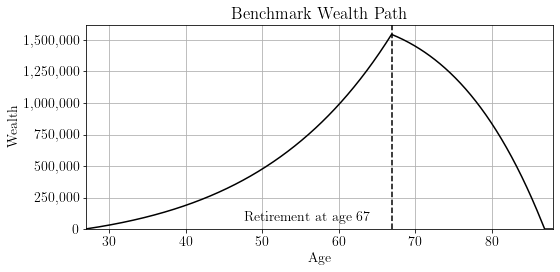

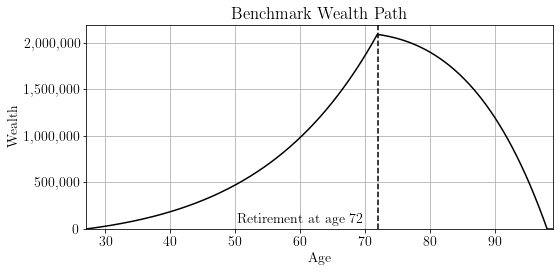

In [22]:
# create plot for the benchmark wealth path
def benchmark_plot(benchmark_wealth_path, retirement_age,xlim,filename=None):
    num_periods = 900

    fig,ax = plt.subplots(1,figsize=(8,4))
    ax.set_facecolor('white') # Set the face color to white
    plt.plot(figsize=(8,8))
    xs = [27 + x/12 for x in range(num_periods)]
    plt.plot(xs, benchmark_wealth_path, color='k')

    # mark retirement date
    plt.axvline(x=retirement_age,linestyle='--',color='k')
    plt.text(retirement_age - xlim[1]*0.22, 60000, 'Retirement at age ' + str(retirement_age))

    plt.title('Benchmark Wealth Path')
    plt.ylabel('Wealth')
    plt.xlabel('Age')
    plt.ylim(0, plt.ylim()[1])
    plt.xlim(xlim)
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.grid(True)
    plt.tight_layout()
    if filename != None:
        plt.savefig(filename,dpi=300)

    plt.show()

benchmark_plot(benchmark_wealth_path, 67,(27,88), filename='benchmark_wealth_path_67')
benchmark_plot(benchmark_wealth_path_70, 72,(27,99), filename='benchmark_wealth_path_72')

In [20]:
for i in range(75*12):
    print('age ', 27 + i/12, benchmark_wealth_path[i])

age  27.0 750.0
age  27.083333333333332 1504.4169200556337
age  27.166666666666668 2263.271226195009
age  27.25 3026.5834723123926
age  27.333333333333332 3794.3743005343285
age  27.416666666666668 4566.664441587263
age  27.5 5343.474715166682
age  27.583333333333332 6124.826030307764
age  27.666666666666668 6910.739385757569
age  27.75 7701.2358703487425
age  27.833333333333332 8496.336663374768
age  27.916666666666668 9296.063034966763
age  28.0 10100.436346471815
age  28.083333333333332 10909.478050832893
age  28.166666666666668 11723.209692970302
age  28.25 12541.652910164714
age  28.333333333333332 13364.82943244178
age  28.416666666666668 14192.761082958321
age  28.5 15025.4697783901
age  28.583333333333332 15862.977529321193
age  28.666666666666668 16705.306440634977
age  28.75 17552.4787119067
age  28.833333333333332 18404.516637797682
age  28.916666666666668 19261.442608451132
age  29.0 20123.2791098896
age  29.083333333333332 20990.048724414053
age  29.166666666666668 21861.7

Adapted from Chen (2019)